# Pulse Data Processing Analysis

This notebook analyzes the results of our pulse data processing pipeline.

In [19]:
import pandas as pd
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visualizations
plt.style.use('seaborn-v0_8')  # or use 'seaborn-darkgrid'
sns.set_theme()  # This sets the seaborn default theme

## 1. Load Processed Data

In [20]:
# Load all processed files
interim_dir = Path('../data/interim')
processed_files = list(interim_dir.glob('pulse_data_*.csv'))

# Read and combine all files
dfs = []
for file in processed_files:
    df = pd.read_csv(file)
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)
print(f"Total records: {len(combined_df)}")
print(f"Unique devices: {combined_df['device_id_encoded'].nunique()}")
print(f"Date range: {combined_df['date'].min()} to {combined_df['date'].max()}")

Total records: 1186
Unique devices: 1159
Date range: 240101 to 240414


## 2. Data Quality Check

In [21]:
# Check for missing values
print("Missing values:")
print(combined_df.isnull().sum())

# Check data types
print("\nData types:")
print(combined_df.dtypes)

Missing values:
device_id_encoded    0
date                 0
data                 0
dtype: int64

Data types:
device_id_encoded    object
date                  int64
data                 object
dtype: object


## 3. Analyze Pulse Data Structure

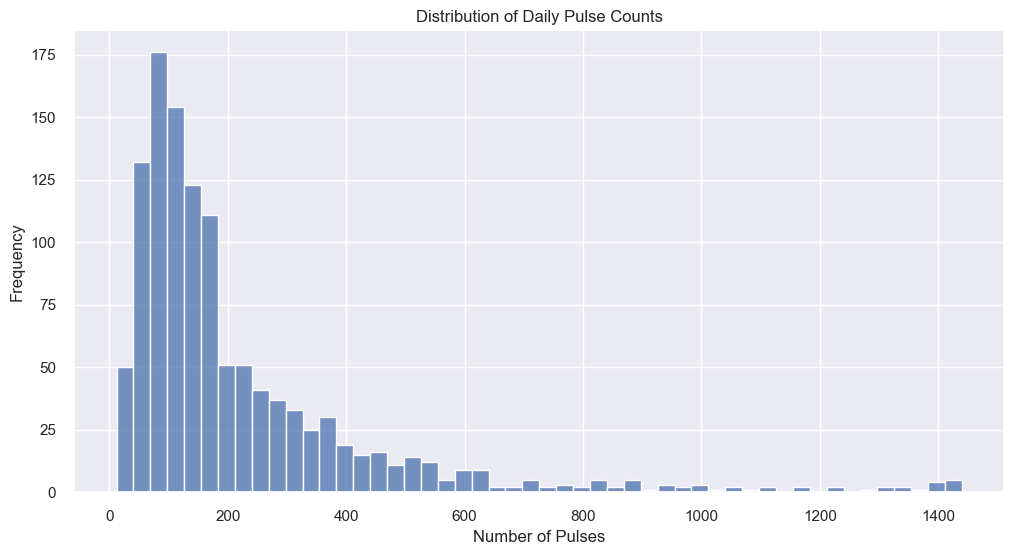

In [22]:
# Function to parse JSON data and extract pulse counts
def extract_pulse_counts(data_str):
    try:
        data = json.loads(data_str)
        pulse_data = data.get('data', [])
        total_pulses = sum(len(record['d'].split('|')) - 1 for record in pulse_data)
        return total_pulses
    except:
        return 0

# Add pulse count column
combined_df['pulse_count'] = combined_df['data'].apply(extract_pulse_counts)

# Show distribution of pulse counts
plt.figure(figsize=(12, 6))
sns.histplot(data=combined_df, x='pulse_count', bins=50)
plt.title('Distribution of Daily Pulse Counts')
plt.xlabel('Number of Pulses')
plt.ylabel('Frequency')
plt.show()

## 4. Time Series Analysis

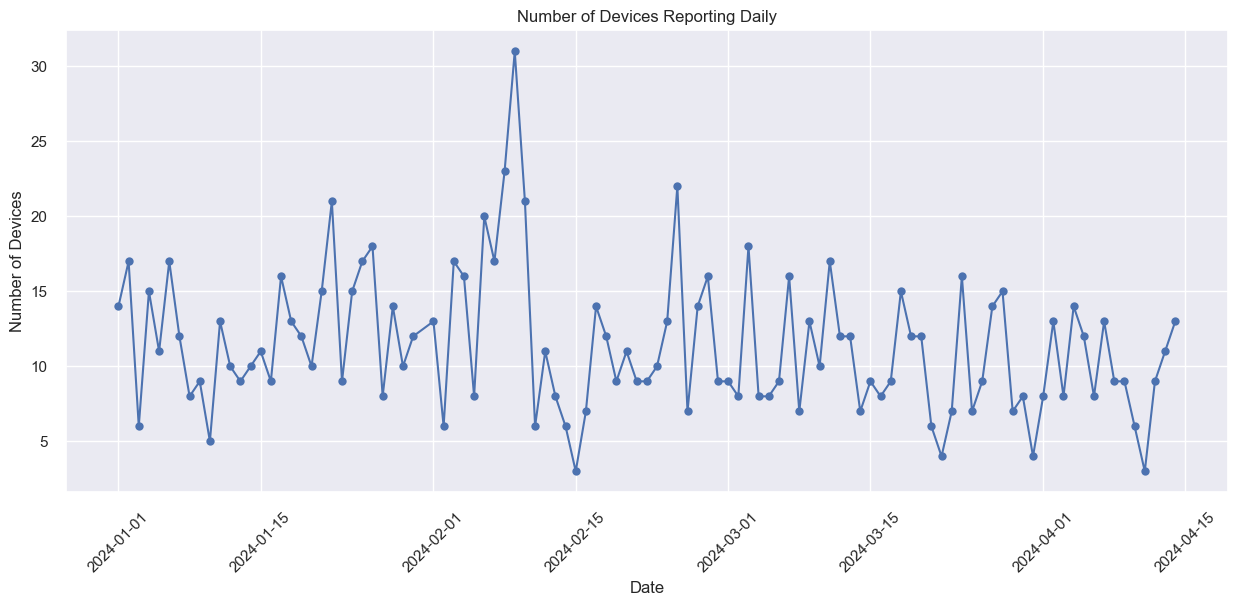

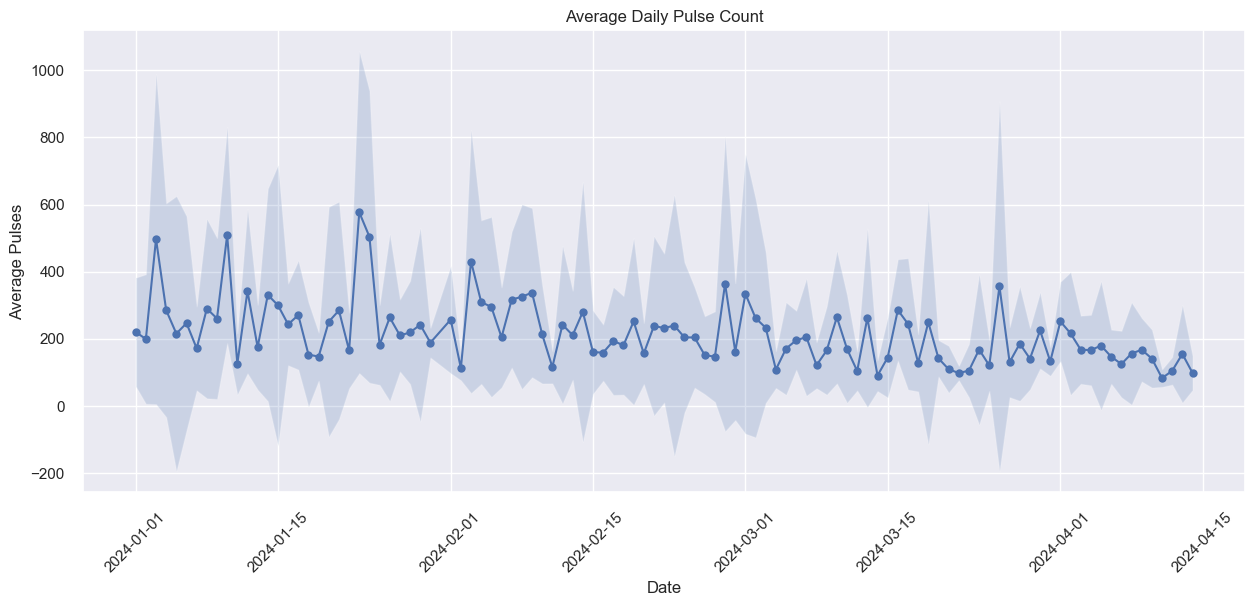

In [23]:
# Convert date strings to datetime
combined_df['date'] = pd.to_datetime(combined_df['date'], format='%y%m%d')

# Group by date and calculate statistics
daily_stats = combined_df.groupby('date').agg({
    'device_id_encoded': 'count',
    'pulse_count': ['mean', 'std', 'min', 'max']
}).reset_index()

# Plot daily device count
plt.figure(figsize=(15, 6))
plt.plot(daily_stats['date'], daily_stats['device_id_encoded'], marker='o')
plt.title('Number of Devices Reporting Daily')
plt.xlabel('Date')
plt.ylabel('Number of Devices')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plot average daily pulse count
plt.figure(figsize=(15, 6))
plt.plot(daily_stats['date'], daily_stats['pulse_count']['mean'], marker='o')
plt.fill_between(daily_stats['date'],
                 daily_stats['pulse_count']['mean'] - daily_stats['pulse_count']['std'],
                 daily_stats['pulse_count']['mean'] + daily_stats['pulse_count']['std'],
                 alpha=0.2)
plt.title('Average Daily Pulse Count')
plt.xlabel('Date')
plt.ylabel('Average Pulses')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## 5. Device Analysis

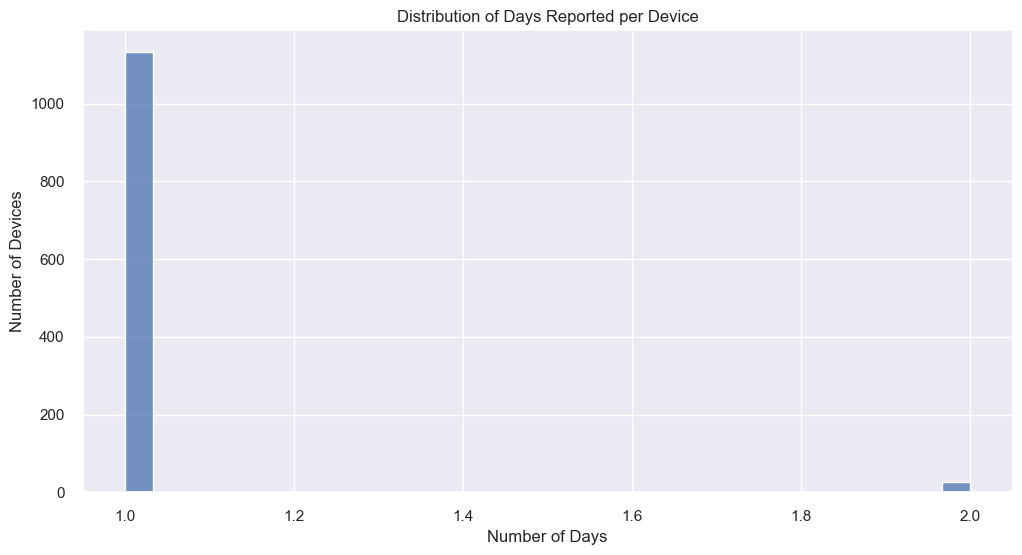

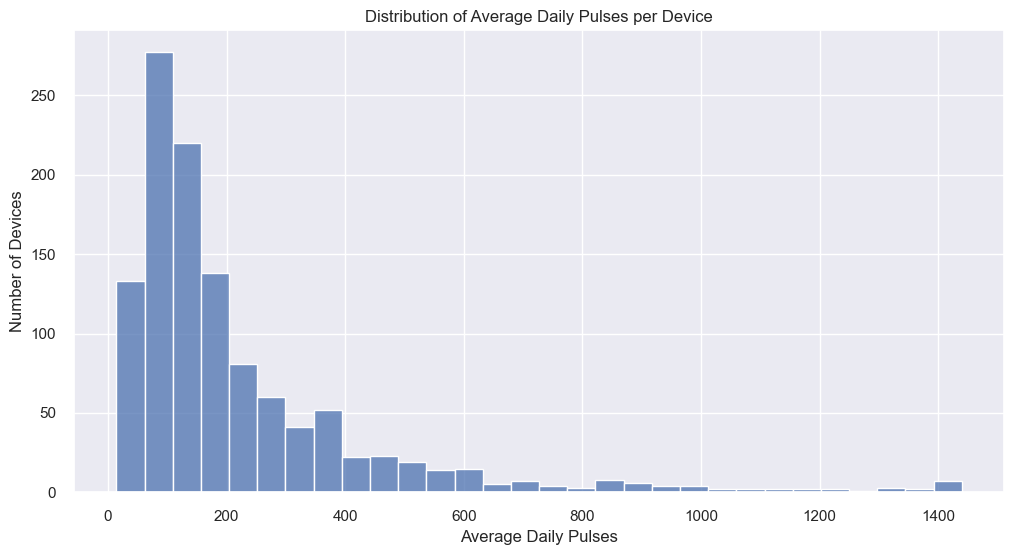

In [24]:
# Calculate device-level statistics
device_stats = combined_df.groupby('device_id_encoded').agg({
    'date': 'count',
    'pulse_count': ['mean', 'std', 'min', 'max']
}).reset_index()

# Flatten column names
device_stats.columns = ['device_id_encoded', 'days_reported', 
                       'pulse_mean', 'pulse_std', 'pulse_min', 'pulse_max']

# Plot devices by number of days reported
plt.figure(figsize=(12, 6))
sns.histplot(data=device_stats, x='days_reported', bins=30)
plt.title('Distribution of Days Reported per Device')
plt.xlabel('Number of Days')
plt.ylabel('Number of Devices')
plt.show()

# Plot devices by average pulse count
plt.figure(figsize=(12, 6))
sns.histplot(data=device_stats, x='pulse_mean', bins=30)
plt.title('Distribution of Average Daily Pulses per Device')
plt.xlabel('Average Daily Pulses')
plt.ylabel('Number of Devices')
plt.show()

## 6. Summary Statistics

In [25]:
print("Dataset Summary:")
print(f"Total number of records: {len(combined_df)}")
print(f"Number of unique devices: {combined_df['device_id_encoded'].nunique()}")
print(f"Date range: {combined_df['date'].min()} to {combined_df['date'].max()}")
print(f"Average pulses per device per day: {combined_df['pulse_count'].mean():.2f}")
print(f"Median pulses per device per day: {combined_df['pulse_count'].median():.2f}")
print(f"Standard deviation of pulses: {combined_df['pulse_count'].std():.2f}")

Dataset Summary:
Total number of records: 1186
Number of unique devices: 1159
Date range: 2024-01-01 00:00:00 to 2024-04-14 00:00:00
Average pulses per device per day: 224.02
Median pulses per device per day: 146.00
Standard deviation of pulses: 232.67
